# Local ToE

- In this version I have added in the other tests (KS, Anerson Darling)

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)

import time_of_emergence.moduls.utils as toe_utils  
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/111963638.gadi-pbs/matplotlib-78dpnkg4 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sys.path.append(os.path.join(os.getcwd(), 'PhD', ''))

In [3]:
# client.close()

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(28)
client

- State start
- Found stale lock file and directory '/jobfs/111963638.gadi-pbs/dask-scratch-space/scheduler-zb29gx23', purging
-   Scheduler at:     tcp://127.0.0.1:40961
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:46051'
-         Start Nanny at: 'tcp://127.0.0.1:41737'
-         Start Nanny at: 'tcp://127.0.0.1:40049'
-         Start Nanny at: 'tcp://127.0.0.1:46777'
-         Start Nanny at: 'tcp://127.0.0.1:37219'
-         Start Nanny at: 'tcp://127.0.0.1:34789'
-         Start Nanny at: 'tcp://127.0.0.1:39235'
-         Start Nanny at: 'tcp://127.0.0.1:43321'
-         Start Nanny at: 'tcp://127.0.0.1:45901'
-         Start Nanny at: 'tcp://127.0.0.1:34513'
-         Start Nanny at: 'tcp://127.0.0.1:38575'
-         Start Nanny at: 'tcp://127.0.0.1:33361'
-         Start Nanny at: 'tcp://127.0.0.1:33695'
-         Start Nanny at: 'tcp://127.0.0.1:42221'
-         Start Nanny at: 'tcp://127.0.0.1:37407

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40961,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:37953,Total threads: 1
Dashboard: /proxy/35707/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:46051,


In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=1, suppress=True, edgeitems=1)

# Opening Best

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

0.3.0


In [8]:
# Only 43MB - load into memory
best_ds = best_ds.compute()

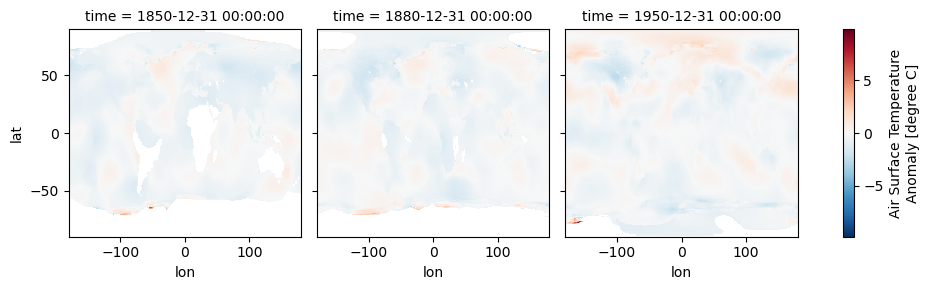

In [9]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [10]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [-0., ..., -0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [11]:
base_period_ds_count = base_period_ds.count(dim='time')

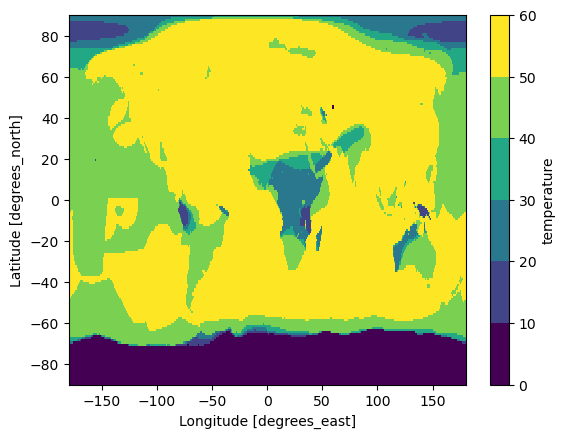

In [12]:
data_availability_levels = np.arange(0, 61, 10)

base_period_ds_count.plot(levels=data_availability_levels)

In [13]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

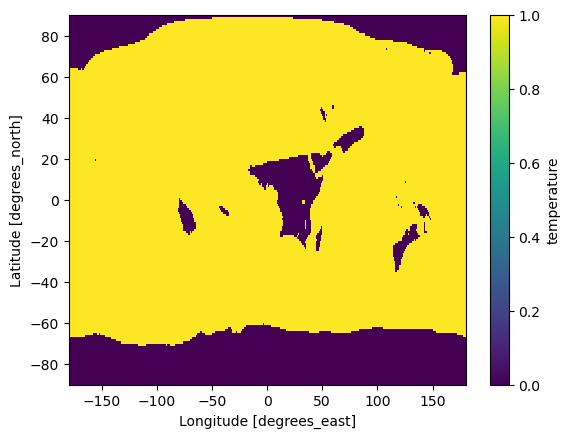

In [14]:
data_availability_mask.plot()

In [15]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)

base_period_ds = base_period_ds.where(data_availability_mask)

In [16]:
best_ds = best_ds - base_period_ds.mean(dim='time')

# Calculations

In [17]:
window = 20

## Signal-to-Noise

In [16]:
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess

In [17]:
def apply_lowess(arr):
    if all(np.isnan(arr)): return arr

    x = np.arange(arr.shape[0])
    yhat = lowess(arr,x, return_sorted=False)
    return yhat

In [18]:
best_ds_smean = best_ds.clima.space_mean()#.plot()
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
array([-0.1, -0. ,  0. ,  0. ,  0. ,  0. , -0.1, -0.2, -0. ,  0.1, -0.1,
       -0.2, -0.2, -0.1, -0. ,  0.1,  0.1,  0.1,  0.1,  0. ,  0. , -0. ,
        0. ,  0. , -0. , -0. , -0. ,  0.3,  0.4,  0.1,  0. ,  0.1,  0.1,
        0. , -0.1, -0.1, -0.1, -0.2,  0. ,  0.1, -0.1,  0. , -0.1, -0.1,
       -0.1,  0. ,  0.1,  0.1, -0.1,  0. ,  0.1,  0.1, -0.1, -0.2, -0.2,
       -0. ,  0. , -0.1, -0.2, -0.2, -0.2, -0.2, -0.1, -0.1,  0.1,  0.1,
       -0.1, -0.2, -0. , -0. ,  0.1,  0.1,  0. ,  0.1,  0. ,  0.1,  0.2,
        0.1,  0.1, -0.1,  0.2,  0.2,  0.2, -0. ,  0.1,  0.1,  0.1,  0.3,
        0.3,  0.3,  0.4,  0.3,  0.3,  0.4,  0.5,  0.4,  0.2,  0.2,  0.2,
        0.2,  0.1,  0.3,  0.4,  0.4,  0.2,  0.2,  0.1,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.1,  0.2,  0.2,  0.2,  0.2,  0.3,  0.3,
        0.1,  0.2,  0.4,  0.2,  0.3,  0.2,  0.5,  0.4,  0.5,  0.5,  0.6,
        0.4,  0.6,  0.4,  0.4,  0.5,  0.6,  0.6,  0.5,  0.7,  0.7,  0.5,
        0.6,  0.6,  0.8,  0.6,  0.8,  0.9,  0.7,  0.7,  0.8,  0.9,  0.9,
        0.8,  0.9,  0.9,  0.9,  0.8,  0.9,  1. ,  0.9,  0.9,  0.9,  1. ,
        1.2,  1.3,  1.2,  1.1,  1.2,  1.3,  1.1,  1.2,  1.5,  1.6],
      dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [19]:
best_ds_smean_lowess = xr.zeros_like(best_ds_smean) + apply_lowess(best_ds_smean.values)

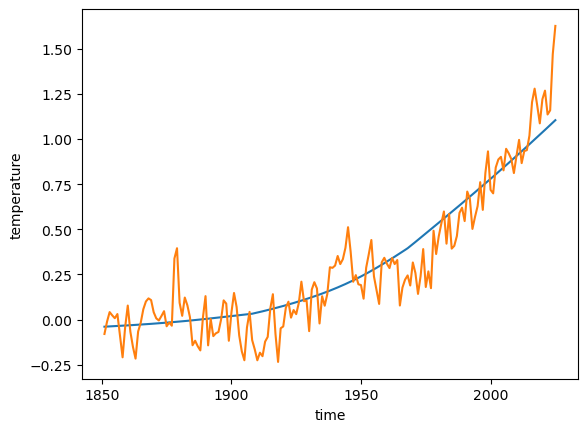

In [20]:
best_ds_smean_lowess.plot()
best_ds_smean.plot()

In [21]:
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=best_ds_smean_lowess.values)

In [22]:
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(best_ds.sel(lat=-14, lon=-115, method='nearest').values, return_reconstruction=True)

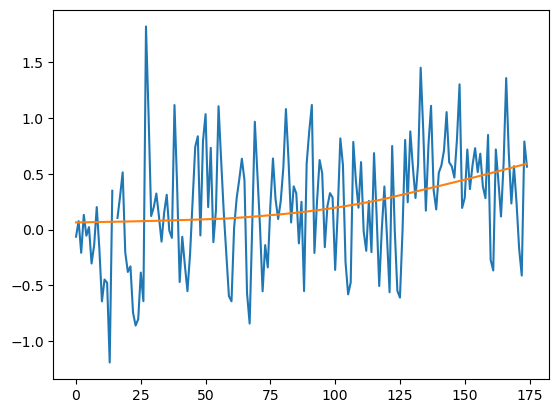

In [23]:
plt.plot(best_ds.sel(lat=-14, lon=-115, method='nearest').values)
plt.plot(reocnstructed_sp)

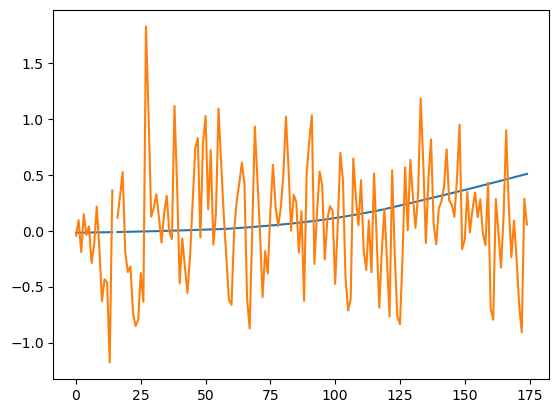

In [24]:
plt.plot(signal_sp)
plt.plot(noise_series_sp)

In [25]:
ds_best_signal, ds_best_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    best_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True
)

In [26]:
ds_best_noise = ds_best_noise_series.std(dim='time')

- Event loop was unresponsive in Scheduler for 6.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [27]:
ds_best_sn = ds_best_signal/ds_best_noise

- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.83s.  This is often caused by long-runni

In [28]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

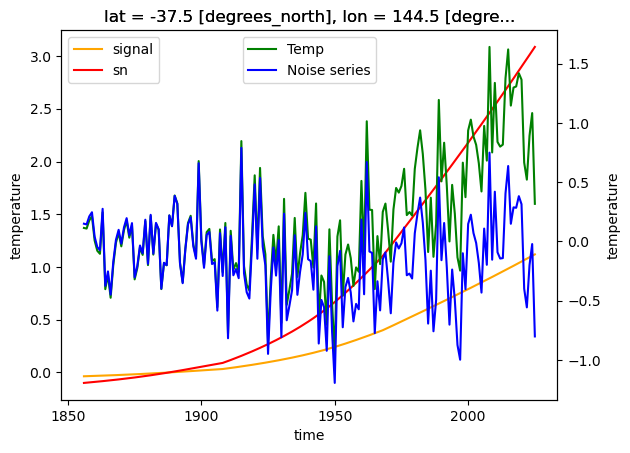

In [29]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
ds_best_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_best_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

best_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_best_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

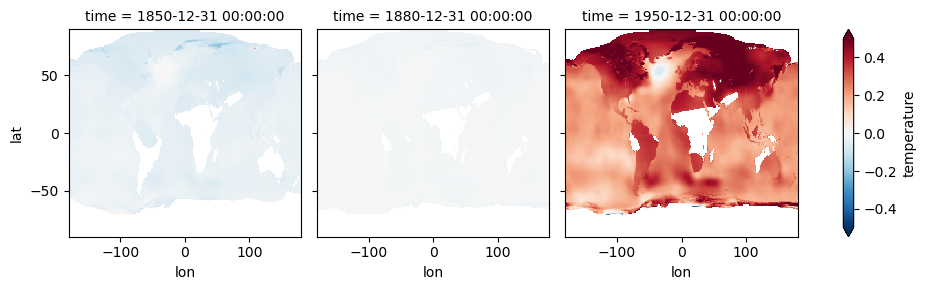

In [30]:
ds_best_signal.isel(time=[0, 30, 100]).plot(col='time', robust=True)

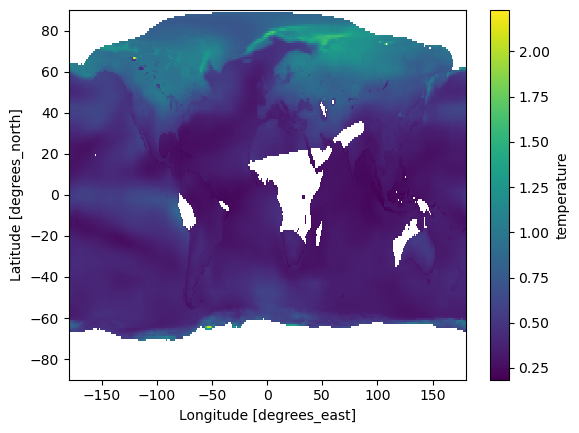

In [31]:
ds_best_noise.plot()

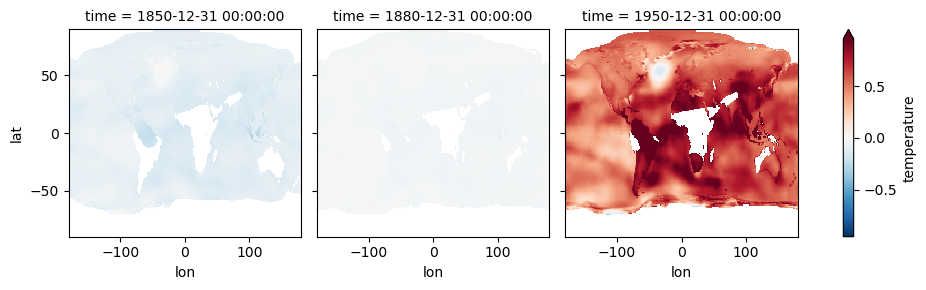

In [32]:
ds_best_sn.isel(time=[0, 30, 100]).plot(col='time', robust=True)

## p-value tests

In [42]:
# Legacy

stats_test_1d_array_ttest = partial(toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

ufunc_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims=[['time']], 
    vectorize=True,
    dask='parallelized')

ttest_1d_ds = xr.apply_ufunc(
    stats_test_1d_array_ttest,
    best_ds.sel(lat=slice(-45, -30), lon=slice(135, 150)),
    **ufunc_kwargs).compute()

- Event loop was unresponsive in Nanny for 3.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.83s.  This is often caused by long-runni

In [21]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':25, 'lon':25, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS

{'lat': 25, 'lon': 25, 'time': -1}

In [41]:
# best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window, center=True, min_periods=window).construct('window_dim').persist()#[(window-1):]
# base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'}).persist()

In [45]:
best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window, center=True, min_periods=window).construct('window_dim').persist() 
base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'}).persist()

In [46]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(50, 180, 360), dtype=float32, chunksize=(50, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [47]:
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360, window_dim: 20)>
dask.array<sliding_window_view, shape=(175, 180, 360, 20), dtype=float32, chunksize=(174, 25, 25, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [48]:
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [49]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 31s, sys: 13.4 s, total: 1min 44s
Wall time: 6min 10s


In [27]:
# %%time
# ttest_ds = xr.apply_ufunc(
#         toe.return_ttest_pvalue,
#         best_ds_window,
#         base_period_window_ds,
#     **rolling_window_kwargs
#     ).compute()

CPU times: user 1min 33s, sys: 12.5 s, total: 1min 46s
Wall time: 6min 7s


In [39]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 12.1 s, sys: 2.3 s, total: 14.4 s
Wall time: 53.2 s


In [28]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [29]:
ttest_test_1d = toe.stats_test_1d_array(best_ds.sel(**lat_lon_sp), stats_func=toe.return_ttest_pvalue)

In [32]:
%%time
ttest_sp_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window.sel(**lat_lon_sp),
        base_period_window_ds.sel(**lat_lon_sp),
    **rolling_window_kwargs
    ).compute()

CPU times: user 274 ms, sys: 13.8 ms, total: 287 ms
Wall time: 291 ms


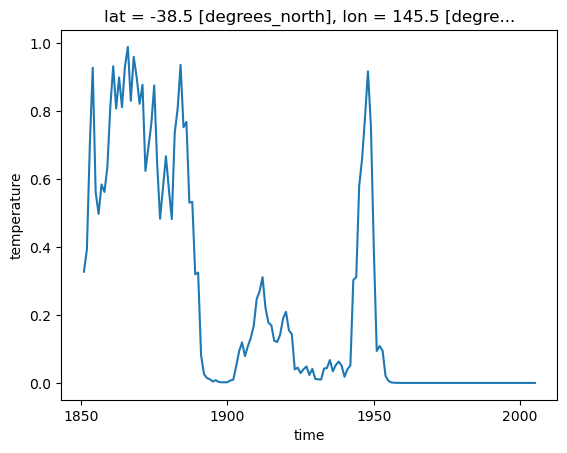

- Connection to tcp://127.0.0.1:57092 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:33221', name: 5, status: running, memory: 9, processing: 0> (stimulus_id='handle-worker-cleanup-1711596258.1950898')
- Connection to tcp://127.0.0.1:57186 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:35739', name: 27, status: running, memory: 7, processing: 1> (stimulus_id='handle-worker-cleanup-1711596258.212936')
- Connection to tcp://127.0.0.1:56984 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:39667', name: 19, status: running, memory: 10, processing: 2> (stimulus_id='handle-worker-cleanup-1711596258.2225213')
- Connection to tcp://127.0.0.1:57072 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:44107', name: 18, status: running, memory: 10, processing: 2> (stimulus_id='handle-worker-cleanup-1711596258.2320213')
- Connection to tcp://127.0.0.1:57104 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:41451', name: 6, status

In [51]:
ttest_1d_ds.sel(**lat_lon_sp).plot()

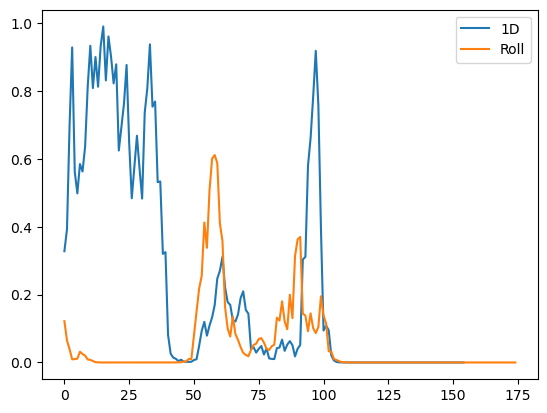

In [50]:
plt.plot(ttest_test_1d, label='1D')
plt.plot(ttest_ds.sel(**lat_lon_sp).values, label='Roll')
plt.legend()

In [40]:
# ks_2samp will perfom on all nan slices
ks_ds = ks_ds.where(data_availability_mask)

In [41]:
anderson_ds = ks_ds

## Emergence Calcs

In [42]:
PVALUE_THESHOLD1 = 0.01

In [43]:
# Finding when each test does not emerge
sn_does_not_emerge = (ds_best_sn.isel(time=-1) <= 2)

ks_does_not_emerge = (ks_ds.isel(time=-1) >= PVALUE_THESHOLD1)

ttest_does_not_emerge = (ttest_ds.isel(time=-1) >= PVALUE_THESHOLD1)

anderson_does_not_emerge = (anderson_ds.isel(time=-1) >= PVALUE_THESHOLD1)

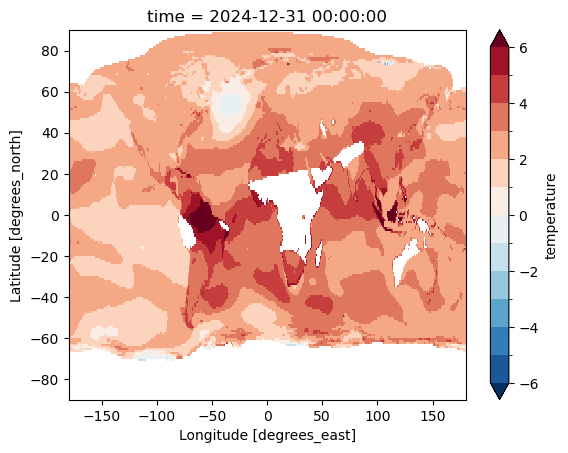

In [44]:
ds_best_sn.isel(time=-1).plot(levels=np.arange(-6, 7, 1), extend='both')

In [45]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(ds_best_sn, threshold=2, comparison_func=np.greater_equal)

ks_toe_ds = toe.get_permanent_exceedance(ks_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

ttest_toe_ds = toe.get_permanent_exceedance(ttest_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

anderson_toe_ds = toe.get_permanent_exceedance(anderson_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

- Event loop was unresponsive in Nanny for 3.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 5.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 5.60s.  This is often caused by long-runni

- Event loop was unresponsive in Nanny for 8.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


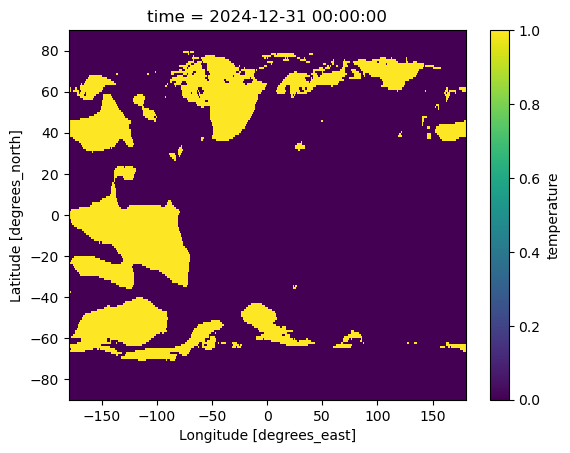

In [46]:
(ds_best_sn.isel(time=-1) <= 2).plot()

# Explorign Odd Patterns

In [47]:
time_indices = np.array([0, 50, 100, 150])

- Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


- Event loop was unresponsive in Nanny for 7.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 5.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 5.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.51s.  This is often caused by long-runni

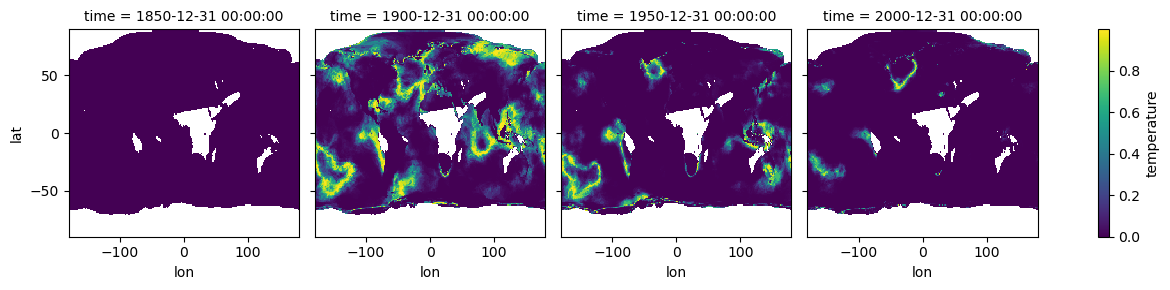

In [48]:
ks_ds.isel(time=time_indices).plot(col='time')

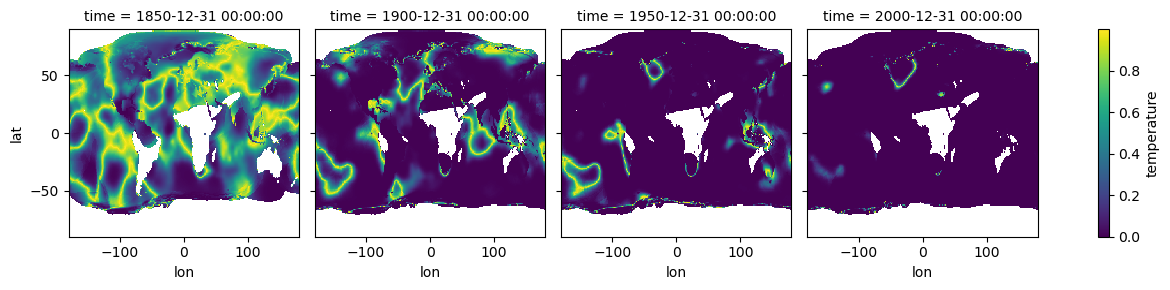

In [49]:
ttest_ds.isel(time=time_indices).plot(col='time')

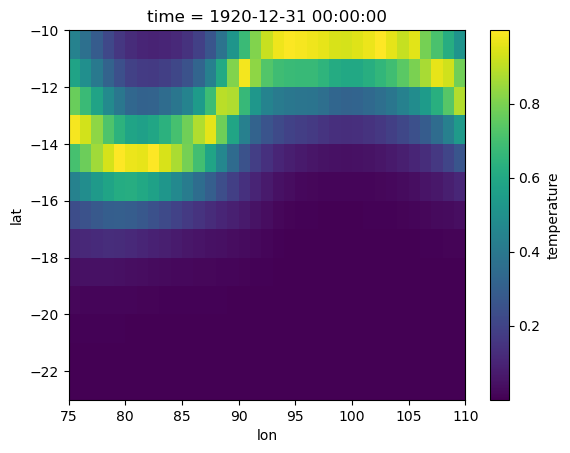

In [50]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))
test_sample_ds.plot()

In [100]:
# Get the lat and lon with the minimum value
min_lat, min_lon = toe_utils.find_nth_extreme_location(test_sample_ds, 'min')
min_lat, min_lon

(-22.5, 101.5)

In [99]:
# Get the lat and lon with the maximum value
max_lat, max_lon = toe_utils.find_nth_extreme_location(test_sample_ds, 'max')
max_lat, max_lon

(-14.5, 82.5)

In [107]:
min_time_series = best_ds.sel(lat=min_lat, lon=min_lon)
max_time_series = best_ds.sel(lat=max_lat, lon=max_lon)

In [108]:
ttest_ds.sel(lat=min_lat, lon=min_lon)

<xarray.DataArray 'temperature' (time: 175)>
array([0.2, 0.2, 0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 0.1,
       0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. ])
Coordinates:
    lat      float32 -22.5
    lon      float32 101.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

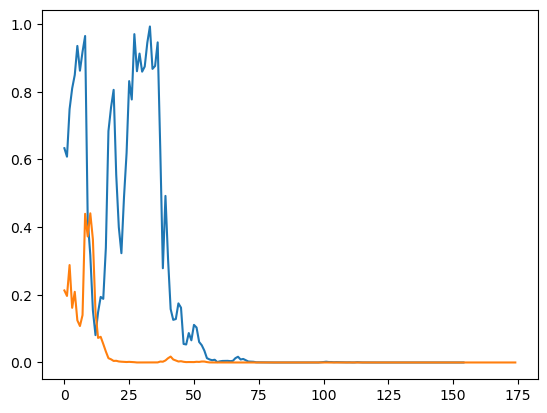

In [110]:
plt.plot( toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue))
plt.plot(ttest_ds.sel(lat=min_lat, lon=min_lon).values)

In [109]:
xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)

<xarray.DataArray 'temperature' (time: 175)>
array([0.6, 0.6, 0.7, 0.8, 0.8, 0.9, 0.9, 0.9, 1. , 0.4, 0.3, 0.2, 0.1,
       0.1, 0.2, 0.2, 0.3, 0.7, 0.8, 0.8, 0.6, 0.4, 0.3, 0.5, 0.6, 0.8,
       0.8, 1. , 0.9, 0.9, 0.9, 0.9, 0.9, 1. , 0.9, 0.9, 0.9, 0.6, 0.3,
       0.5, 0.3, 0.2, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])
Coordinates:
    lat      float32 -22.5
    lon      float32 101.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [103]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [58]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

Text(0, 0.5, 'Temperature\nAnomaly')

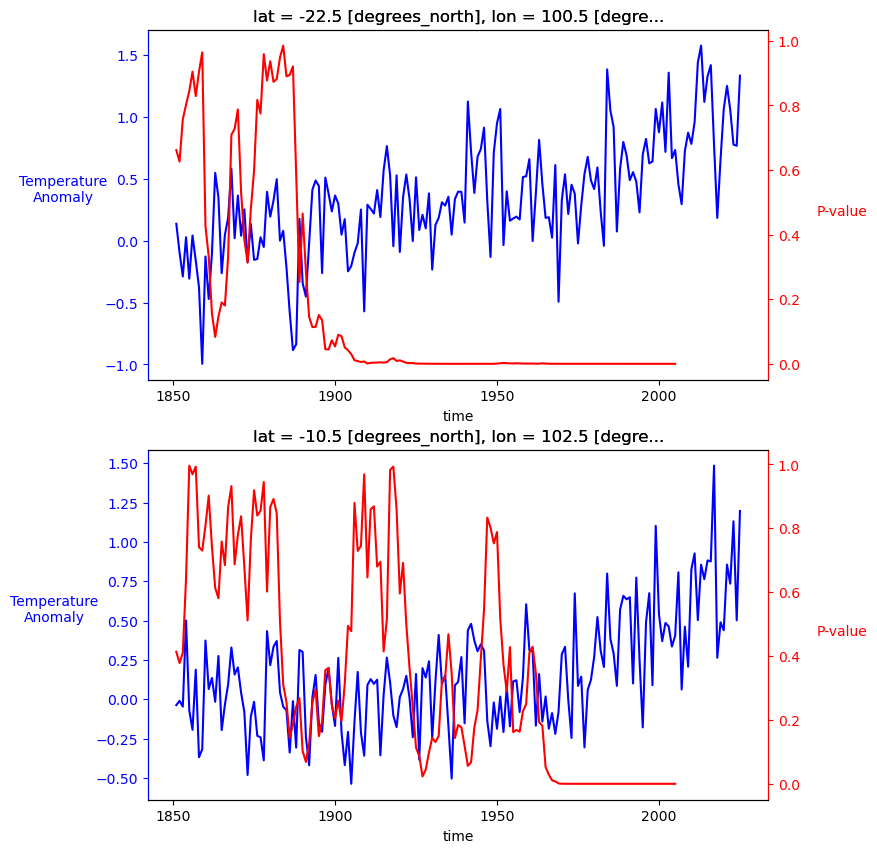

In [59]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

# Plotting

In [60]:
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

In [61]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [62]:
not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'Anderson')

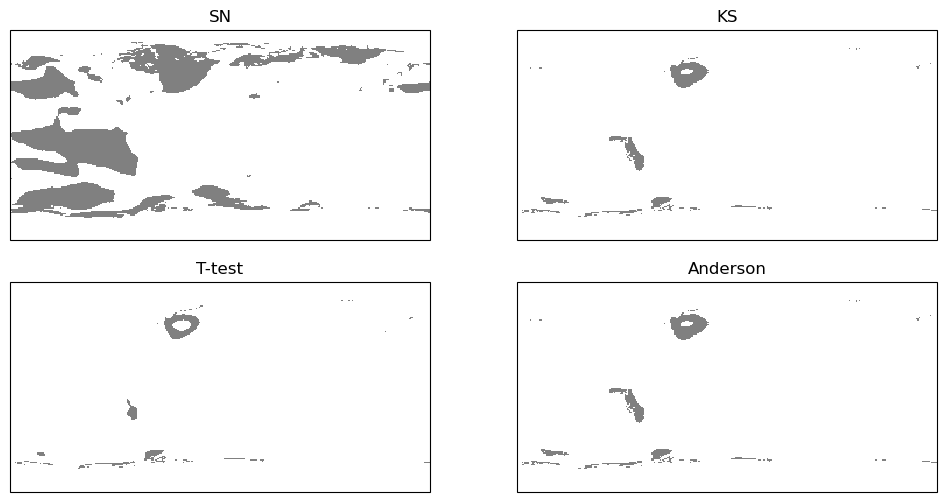

In [63]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
anderson_does_not_emerge.plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [64]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [65]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [66]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

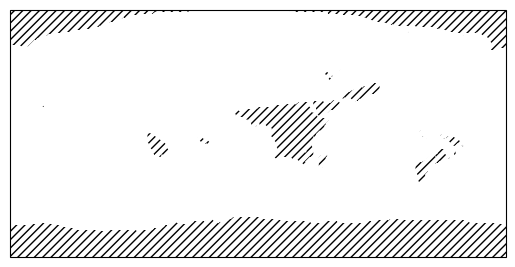

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, xr.where(data_availability_mask, False, True), **not_stable_kwargs)

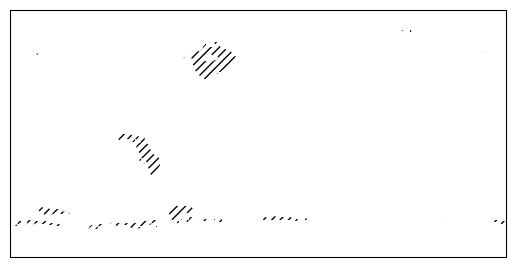

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, ks_does_not_emerge, **not_stable_kwargs)

## Comparison

In [69]:
from scipy.stats import spearmanr

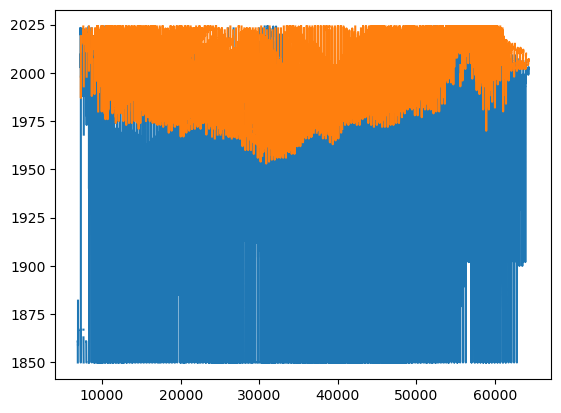

In [70]:
plt.plot(ks_toe_ds.values.flatten())
plt.plot(sn_toe_ds.values.flatten())

In [71]:
spearmanr(ks_toe_ds.values.flatten(), sn_toe_ds.values.flatten(), nan_policy='omit').statistic

0.4671690918406662

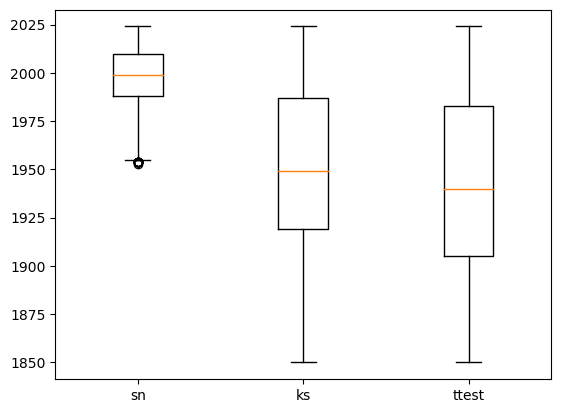

In [72]:
fig, ax = plt.subplots()

bins = np.arange(1900, 2025, 5)
ax.boxplot([sn_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(), 
            ks_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            ttest_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten()],
          labels=['sn', 'ks', 'ttest']);

Text(0.5, 1.0, 'T-test')

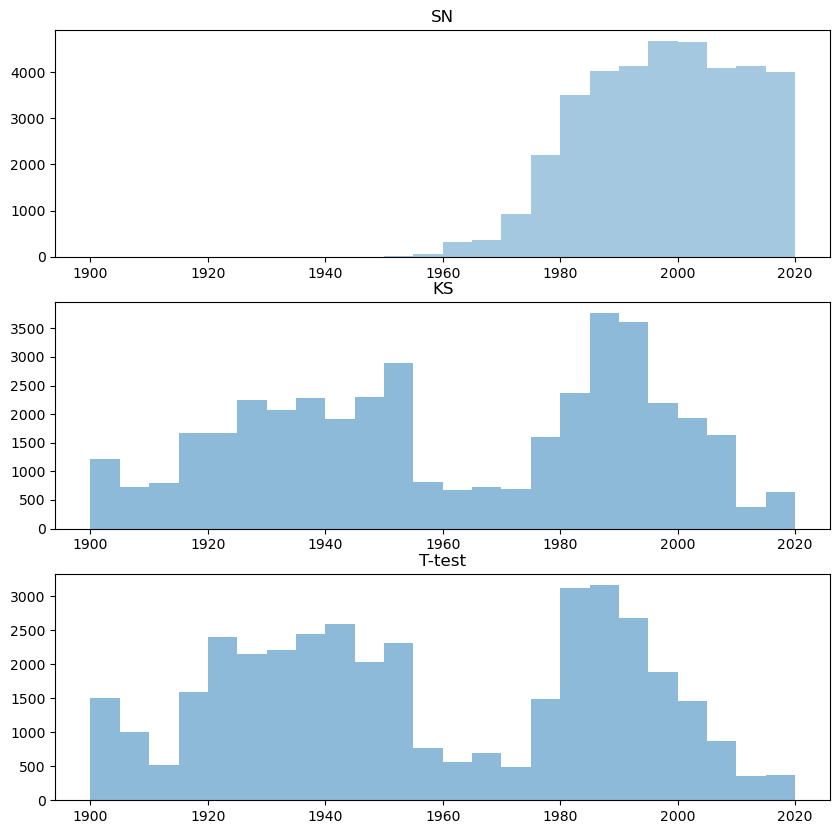

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

bins = np.arange(1900, 2025, 5)
ax1.hist(sn_toe_ds.values.flatten(), bins=bins, alpha=0.4, label='sn')
ax2.hist(ks_toe_ds.values.flatten(), bins=bins, alpha=0.5, label='ks')
ax3.hist(ttest_toe_ds.values.flatten(), bins=bins, alpha=0.5, label='ttest')

ax1.set_title('SN')
ax2.set_title('KS')
ax3.set_title('T-test')

In [74]:
difference_sn_ks_ds = sn_toe_ds - ks_toe_ds

In [75]:
from typing import NamedTuple
from enum import Enum

In [76]:
class LatLonBox(NamedTuple):
    lats: tuple
    lon: tuple

In [77]:
from pydantic import BaseModel

In [78]:
class LocationBoxes(Enum):
    NORTH_AMERICA = dict(lat=slice(10, 66), lon=slice(-160, -49))


In [ ]:
import 

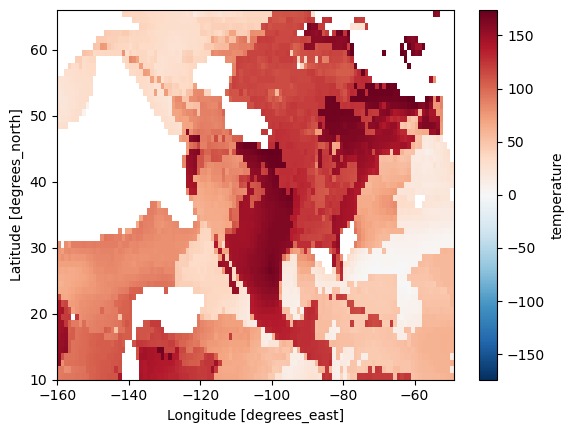

In [79]:
difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value).plot()

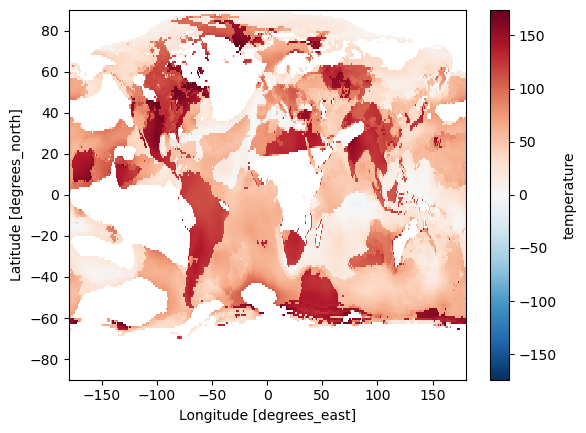

In [84]:
difference_sn_ks_ds.plot()

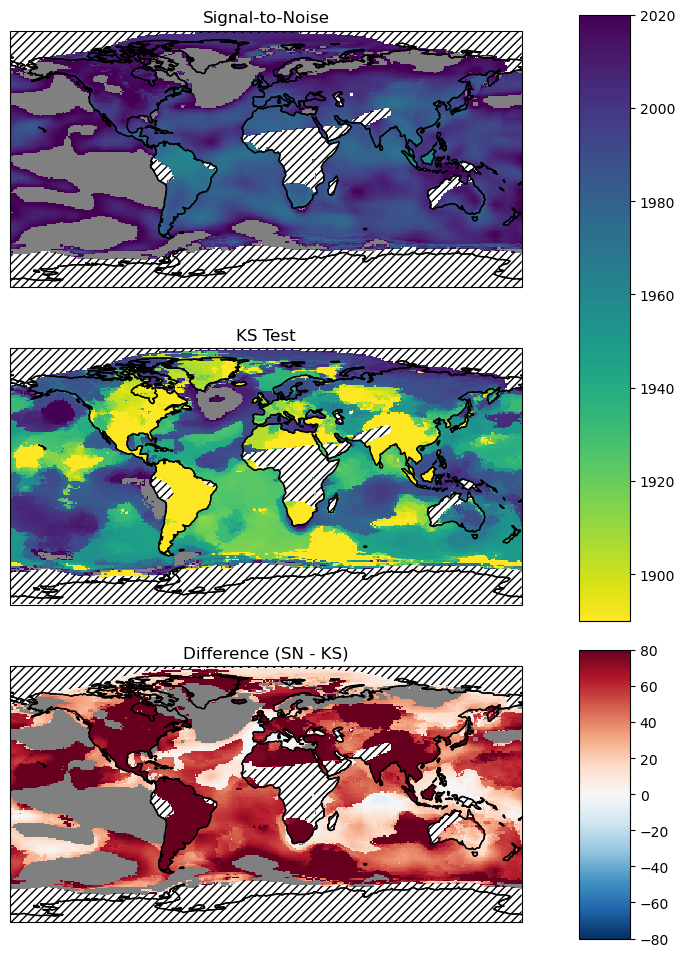

In [81]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
(ks_does_not_emerge | sn_does_not_emerge).plot(ax=axes[2], **not_stable_kwargs2)

sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = difference_sn_ks_ds.plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


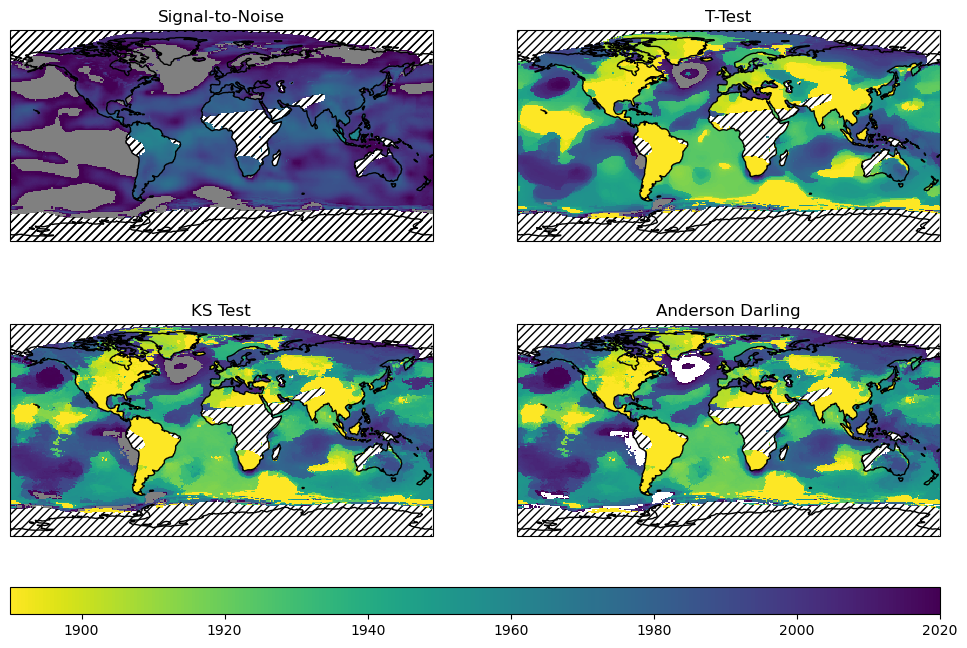

In [82]:
fig = plt.figure(figsize=(12, 8))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

# Signal-to-noise
sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
axes[0].set_title('Signal-to-Noise')
hatch(axes[0], data_unavailability_mask, **not_stable_kwargs)

# T-test
ttest_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)
axes[1].set_title('T-Test')
hatch(axes[1], xr.where(data_availability_mask, 0, 1), **not_stable_kwargs)


# KS Test
ks_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
toe_plot = ks_toe_ds.plot(ax=axes[2], **toe_plot_kwargs)
axes[2].set_title('KS Test')
# hatch(axes[2], ks_does_not_emerge, **not_stable_kwargs)


# Anderson Darling
anderson_toe_ds.plot(ax=axes[3], **toe_plot_kwargs)
axes[3].set_title('Anderson Darling')

cbar_axes1 = plt.subplot(gs[2, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


AttributeError: QuadMesh.set() got an unexpected keyword argument 'hatches'

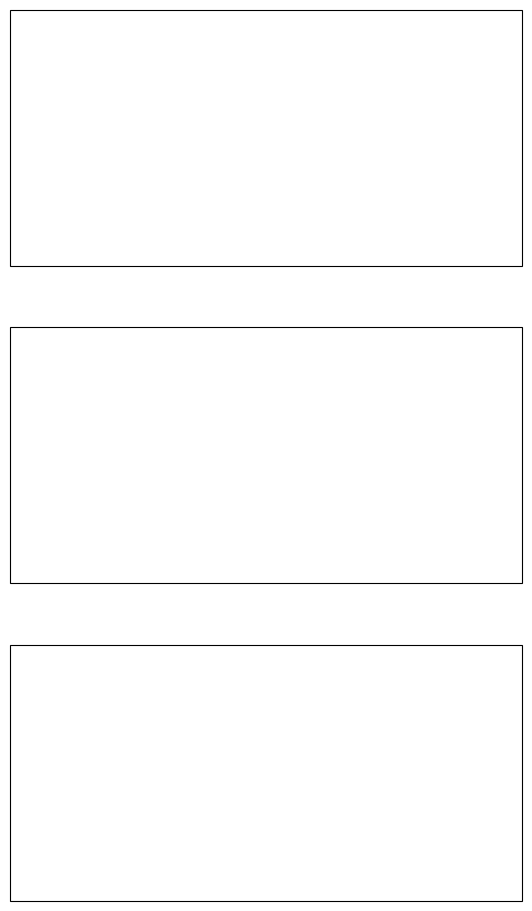

In [83]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs)


sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
fig = plt.figure(figsize=(16, 4))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[0, i], projection=projection) for i in range(3)]

sn_toe_ds.plot(ax=axes[0], add_colorbar=False, vmin=1850, vmax=2010)
toe_plot = ks_toe_ds.plot(ax=axes[1], add_colorbar=False, vmin=1850, vmax=2010)

cbar_axes1 = plt.subplot(gs[1, :2])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[1, 2])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='horizontal')


axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
lat=3.263204
lon=12.78272

In [ ]:
selection_kwargs = dict(lat=lat, lon=lon, method='nearest')

In [ ]:
ks_toe_ds

In [ ]:
ks_toe_ds.sel(**selection_kwargs).values

In [ ]:
sn_toe_ds.sel(**selection_kwargs).values

In [ ]:
best_ds.sel(**selection_kwargs).plot()